In [106]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import tessreduce as tr
from tessreduce import *

|   Sector | Covers   |   Time difference  |
|          |          |             (days) |
|----------+----------+--------------------|
|       23 | True     |                  0 |
|       24 | False    |                  8 |
|       50 | False    |                717 |
getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
calculating centroids


<IPython.core.display.Javascript object>


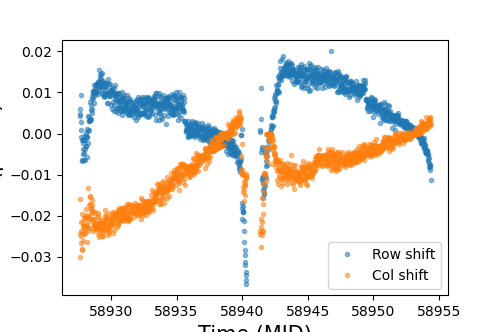

!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction
Field calibration
Target is above -30 dec, calibrating to PS1 photometry.


<IPython.core.display.Javascript object>


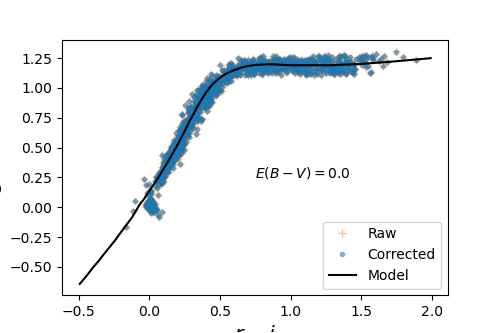

<IPython.core.display.Javascript object>


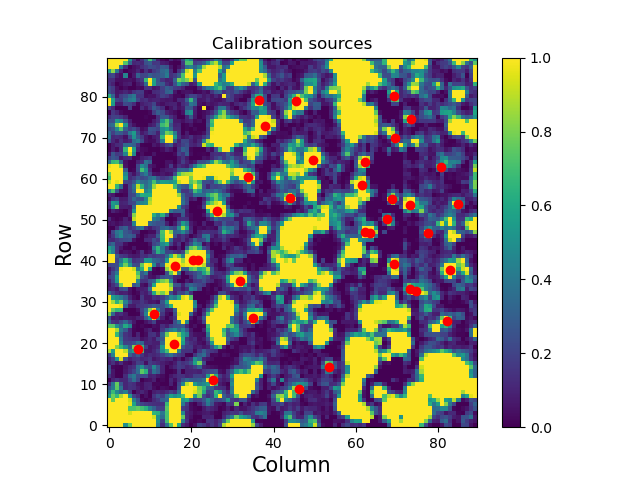

<IPython.core.display.Javascript object>


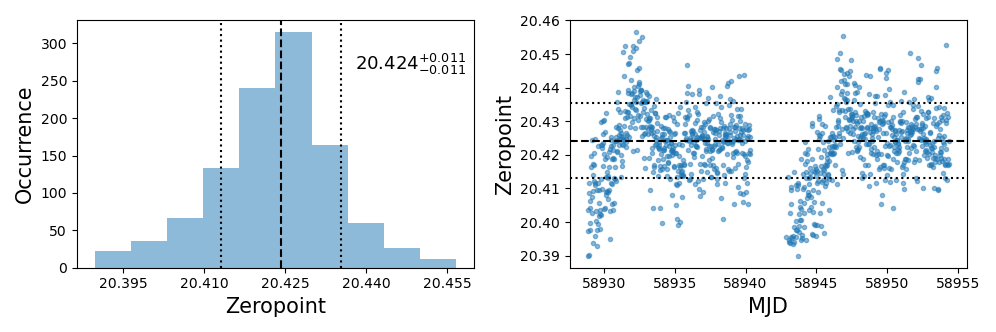

<IPython.core.display.Javascript object>


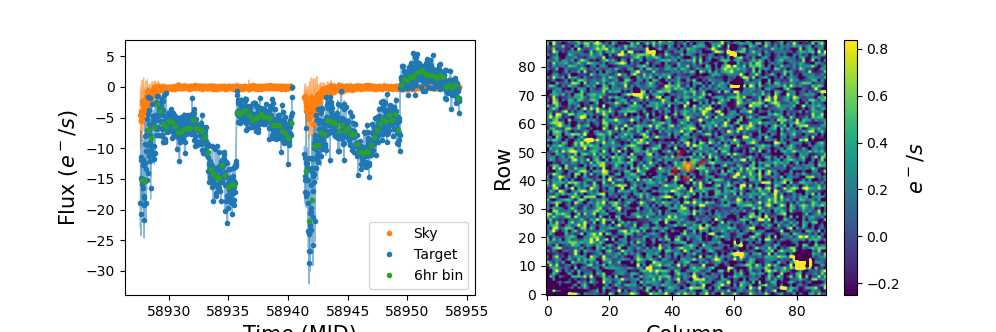

getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
!!Re-running for difference image!!
7
remade mask
background
Background correlation correction
Field calibration
Target is above -30 dec, calibrating to PS1 photometry.


<IPython.core.display.Javascript object>


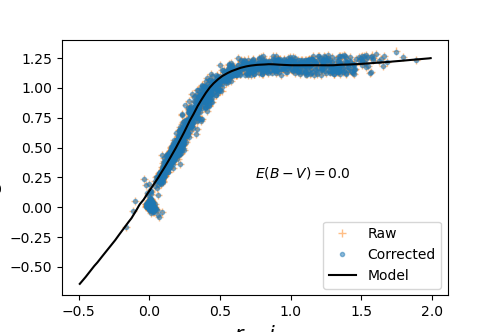

<IPython.core.display.Javascript object>


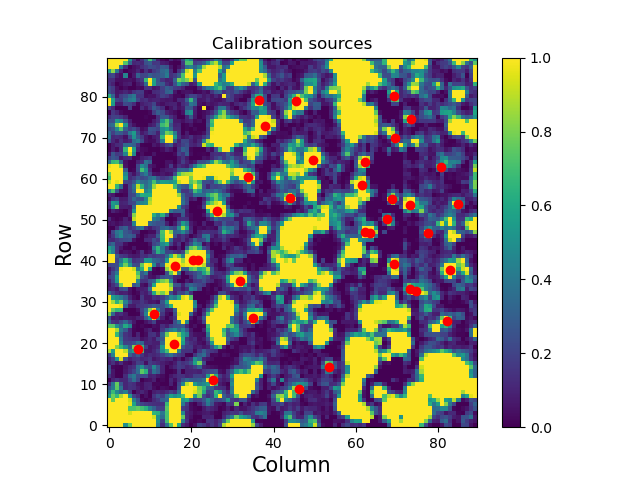

<IPython.core.display.Javascript object>


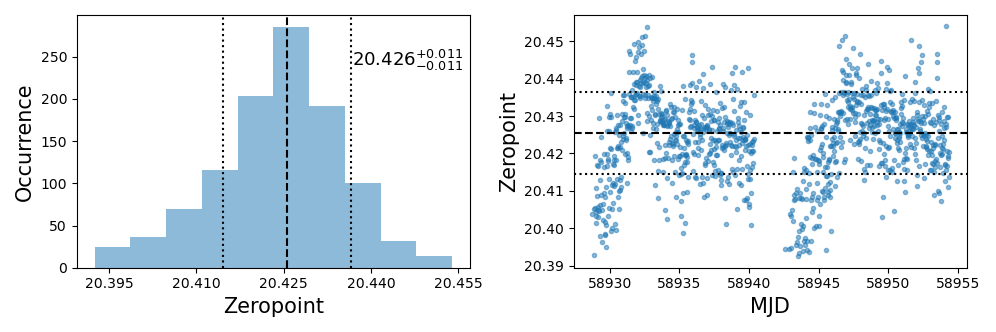

<IPython.core.display.Javascript object>


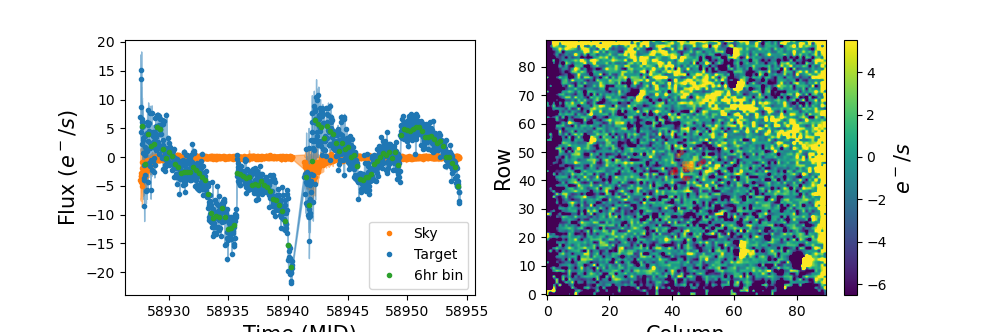

In [161]:
obj = tr.sn_lookup('2020ghq')
tess = tr.tessreduce(obs_list=obj,reduce=True,plot=True,align=True)

getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
!!Re-running for difference image!!
7
remade mask
background
Background correlation correction
Field calibration
Target is above -30 dec, calibrating to PS1 photometry.


<IPython.core.display.Javascript object>


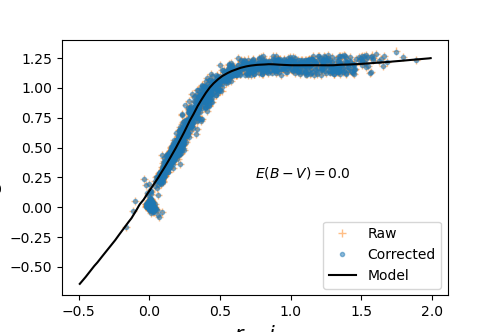

<IPython.core.display.Javascript object>


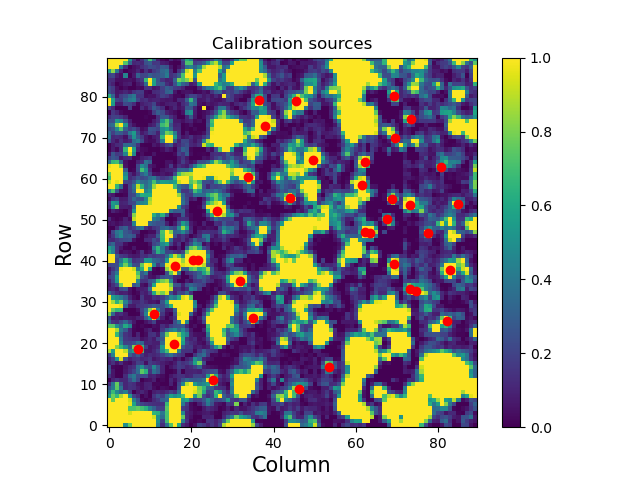

<IPython.core.display.Javascript object>


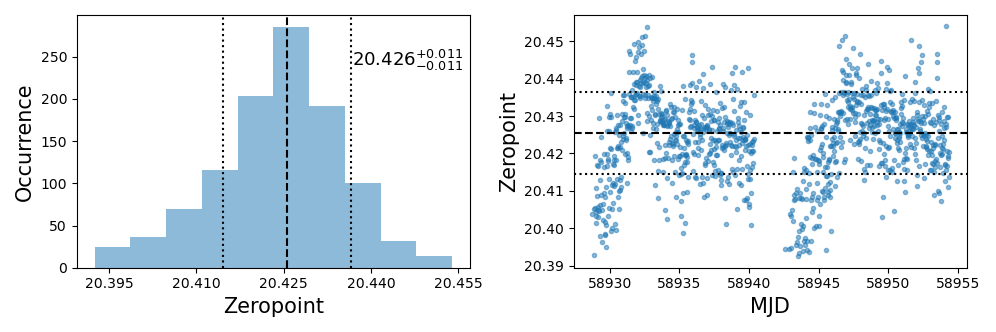

<IPython.core.display.Javascript object>


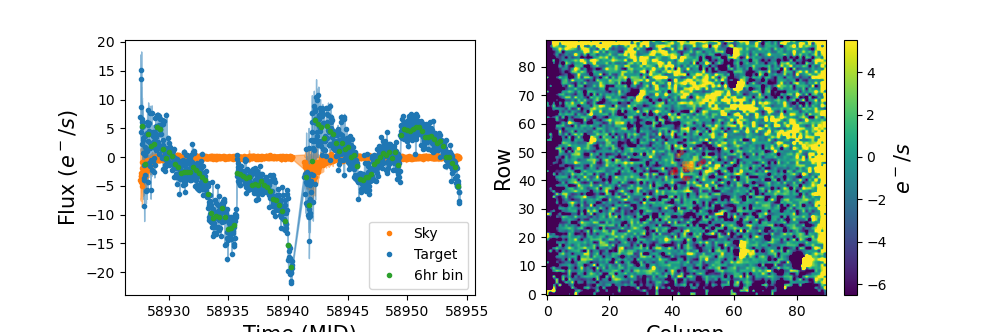

In [163]:
tess2 = tr.tessreduce(obs_list=obj,reduce=True,plot=True,align=False)

In [10]:
a
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [15]:
X = np.array([tess.lc[0],tess.flux[:,10,80]])
ind = np.isfinite(X[1])
X = X[:,ind]

In [8]:
X.shape

(2, 1235)

In [16]:
pca.fit(X)

PCA(n_components=2)

In [17]:
pca.explained_variance_ratio_

array([1.0000000e+00, 1.0613007e-32])

In [18]:
pca.singular_values_

array([1.46388667e+06, 1.50808799e-10])

<IPython.core.display.Javascript object>


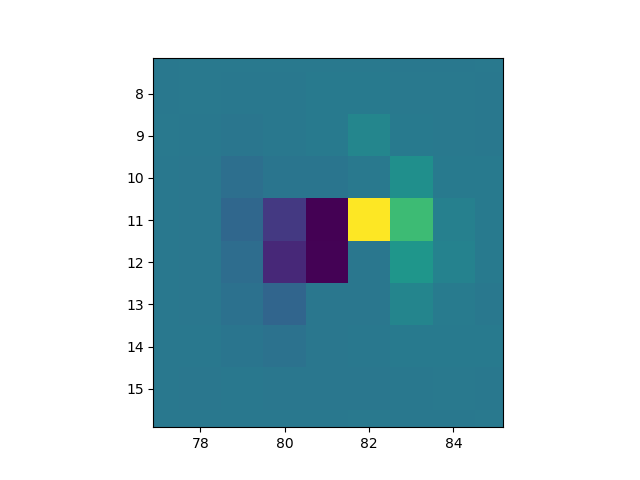

In [152]:
plt.figure()
plt.imshow(tess.flux[100])

In [109]:
inds = np.where(np.ones_like(tess.mask))

In [110]:
len(inds[0])

8100

In [169]:
ii = 53; jj =13
cors = np.zeros_like(tess.flux[0])
for i in range(len(inds[0])):
    t1 = tess.flux[:,ii,jj]
    t2 = tess.flux[:,inds[0][i],inds[1][i]]
    finite = np.isfinite(t1) & np.isfinite(t2)
    t1 = savgol_filter(t1[finite],13,1); t2 = savgol_filter(t2[finite],13,1)
    cors[inds[0][i],inds[1][i]] = pearsonr(t1,t2)[0]
#cors[42:48,42:48] = 0

cors2 = np.zeros_like(tess.flux[0])
for i in range(len(inds[0])):
    t1 = tess2.flux[:,ii,jj]
    t2 = tess2.flux[:,inds[0][i],inds[1][i]]
    finite = np.isfinite(t1) & np.isfinite(t2)
    t1 = savgol_filter(t1[finite],13,1); t2 = savgol_filter(t2[finite],13,1)
    cors2[inds[0][i],inds[1][i]] = pearsonr(t1,t2)[0]
#cors[42:48,42:48] = 0

In [223]:
x,y = tess.wcs.all_world2pix(tess.cat.RAJ2000.values,tess.cat.DEJ2000.values,0)
indo = (x >10) & (x<tess.flux.shape[2]-10) & (y >10) & (y<tess.flux.shape[1]-10)
x = x[indo]; y = y[indo]
m = tess.cat.rmag.values[indo]

<IPython.core.display.Javascript object>


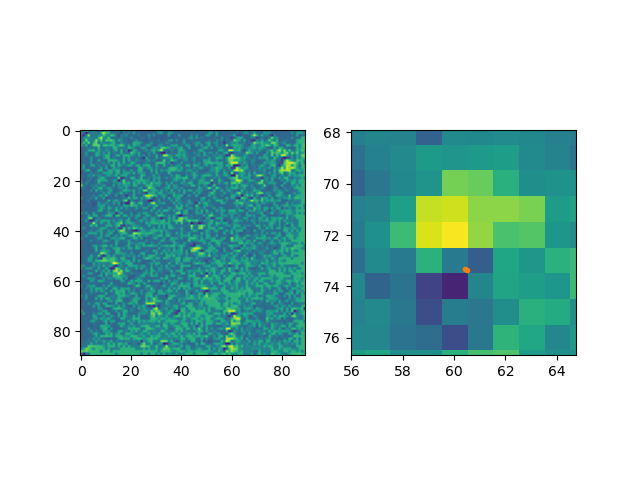

In [208]:
ind = m < 13
plt.figure()
plt.subplot(121)
plt.imshow(cors)
plt.subplot(122)
plt.imshow(cors2)
plt.plot(x[ind],y[ind],'C1.')

<IPython.core.display.Javascript object>


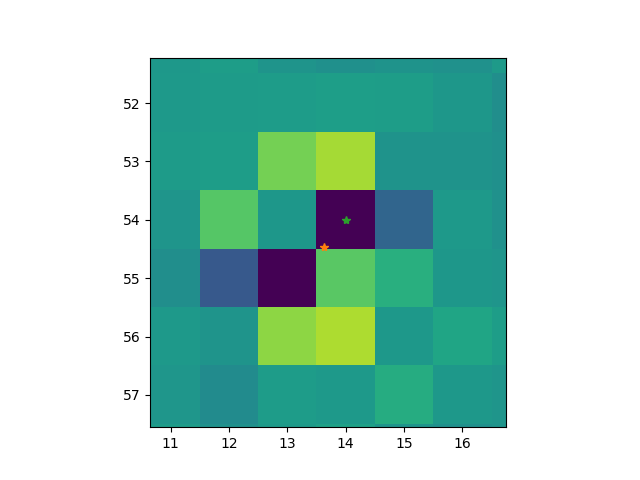

In [212]:
plt.figure()
plt.imshow(tess.flux[380],vmax = 10,vmin=-10)
plt.plot(x[ind],y[ind],'C1*')
plt.plot((x+.5).astype(int)[ind],(y+.5).astype(int)[ind],'C2*')

In [219]:
from astropy.modeling.functional_models import Gaussian2D

In [275]:
gauss = Gaussian2D(x_mean=3,y_mean=3,x_stddev=0,y_stddev=0,theta=0)

In [276]:
xx,yy = np.meshgrid(np.arange(7),np.arange(7))
g = gauss(xx,yy)

<IPython.core.display.Javascript object>


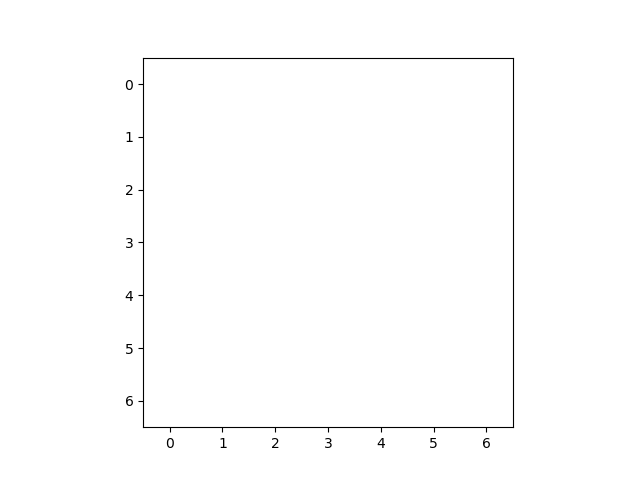

In [277]:
plt.figure()
plt.imshow(g)

In [254]:
from scipy import signal

In [285]:
def image_sub(theta, image, ref):
    dx, dy, x_std, y_std, ang = theta
    s = shift(image,([dx,dy]))
    #if (x_std > 0) | (y_std > 0):
    gauss = Gaussian2D(x_mean=3,y_mean=3,x_stddev=x_std,y_stddev=y_std,theta=ang)
    xx,yy = np.meshgrid(np.arange(7),np.arange(7))
    g = gauss(xx,yy)
    ref = signal.fftconvolve(ref,g,mode='same')
    diff = (ref-s)**2
    return np.nansum(diff[20:-20,20:-20])

In [288]:
x0= [0,0,0,0,0]
bds = [[-10,10],[-10,10],[1e-2,10],[1e-2,10],[0,180]]
res = minimize(image_sub,x0,args=(tess2.flux[380]+tess2.ref,tess2.ref),method = 'Nelder-Mead',bounds=bds)

In [295]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1000.3145533287025
             x: [ 1.316e-02 -8.953e-03  1.299e-02  1.942e-02  2.596e-03]
           nit: 81
          nfev: 141
 final_simplex: (array([[ 1.316e-02, -8.953e-03, ...,  1.942e-02,
                         2.596e-03],
                       [ 1.315e-02, -8.966e-03, ...,  1.943e-02,
                         2.603e-03],
                       ...,
                       [ 1.316e-02, -8.955e-03, ...,  1.944e-02,
                         2.595e-03],
                       [ 1.315e-02, -8.947e-03, ...,  1.942e-02,
                         2.595e-03]]), array([ 1.000e+03,  1.000e+03,  1.000e+03,  1.000e+03,
                        1.000e+03,  1.000e+03]))

In [293]:
dx, dy, x_std, y_std, ang = res.x
gauss = Gaussian2D(x_mean=3,y_mean=3,x_stddev=x_std,y_stddev=y_std,theta=ang)
xx,yy = np.meshgrid(np.arange(7),np.arange(7))
g = gauss(xx,yy)
ref = signal.fftconvolve(deepcopy(tess2.ref),g,mode='same')

<IPython.core.display.Javascript object>


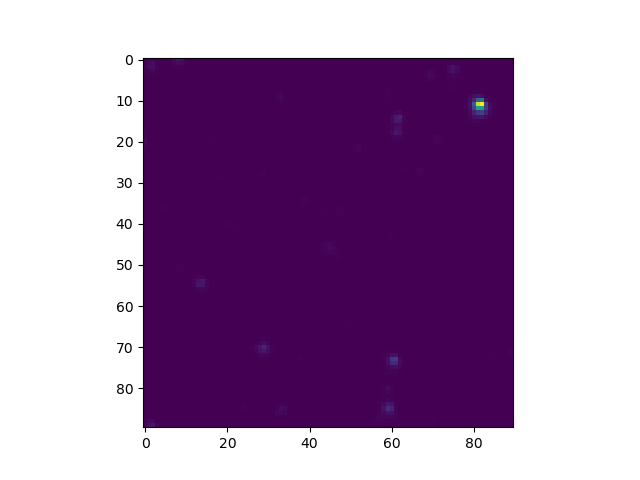

In [297]:
plt.figure()
plt.imshow(tess2.flux[380]+tess2.ref)

In [272]:
np.where(np.isnan(tess2.flux[380]))

(array([], dtype=int64), array([], dtype=int64))

In [274]:
signal.fftconvolve(tess2.ref,g,mode='same')

array([[ 1.90566601e+02,  4.02495642e+02,  4.43664746e+02, ...,
         1.17187350e+00, -6.55328437e-01, -1.52731218e+00],
       [ 4.06544213e+02,  8.78131682e+02,  9.69845566e+02, ...,
         2.28897979e+00,  5.82341004e-01, -1.03265327e+00],
       [ 4.78911209e+02,  1.00228150e+03,  1.07842138e+03, ...,
         2.75600797e+00,  2.31889002e+00, -3.28063182e-02],
       ...,
       [ 1.28366473e+02,  2.58889137e+02,  2.69472567e+02, ...,
         8.15057727e+00,  1.12871329e+01,  1.67456672e+01],
       [ 3.26418157e+02,  7.12945604e+02,  7.82743765e+02, ...,
         2.86977169e+01,  1.62692019e+01,  1.30693647e+01],
       [ 4.16617223e+02,  9.33926407e+02,  1.03788082e+03, ...,
         4.49621724e+01,  1.98255306e+01,  9.13360167e+00]])

<IPython.core.display.Javascript object>


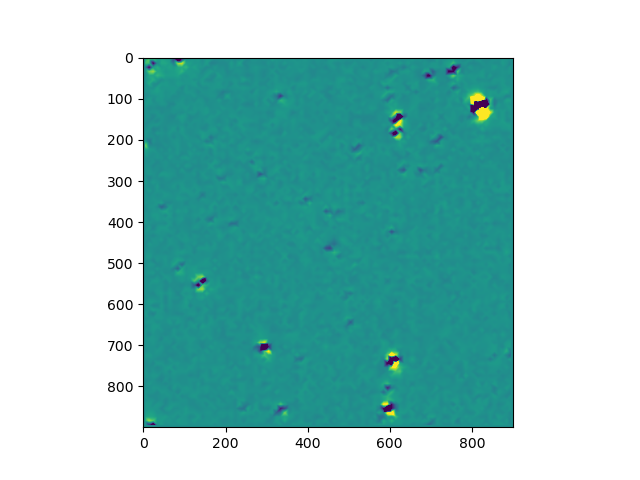

In [218]:
plt.figure()
plt.imshow(estimate,vmin=-10,vmax=10)

In [209]:
rad = 3
cuts = []
for i in range(len(x)):
    cut = tess.flux[380,y[i]-rad:y[i]+rad+1,x[i]-rad:x[i]+rad+1]
    cuts += [cut]
cuts = np.array(cuts)

TypeError: slice indices must be integers or None or have an __index__ method

In [136]:
indo = np.where(abs(cors) >0.9)

In [137]:
indo

(array([10, 13, 14, 45, 71, 75]), array([33, 82, 82, 45, 29, 61]))

<IPython.core.display.Javascript object>


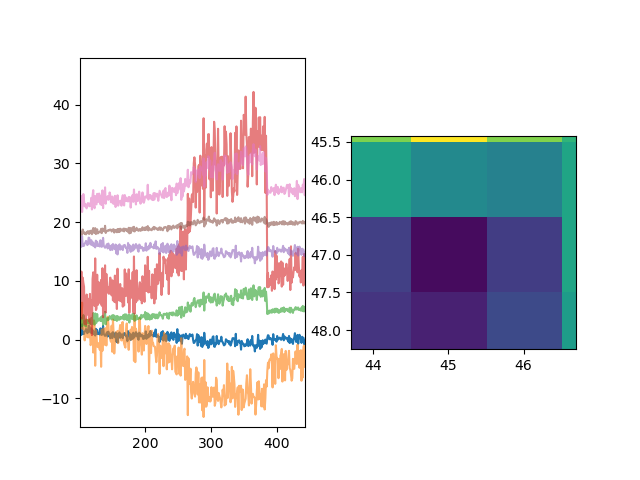

In [138]:
plt.figure()
plt.subplot(121)
plt.plot(tess.flux[:,45,45])
counter = 0
for i in range(len(indo[0])):
    f = tess.flux[:,indo[0][i],indo[1][i]]
    f /= np.nanmedian(f)
    if cors[indo[0][i],indo[1][i]] < 0:
        f *= -1
    plt.plot(f+5*counter,alpha=0.6)
    counter += 1
plt.subplot(122)
plt.imshow(cors)
plt.plot(indo[1],indo[0],'C1*')


In [145]:
tess.tpf.

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

<IPython.core.display.Javascript object>


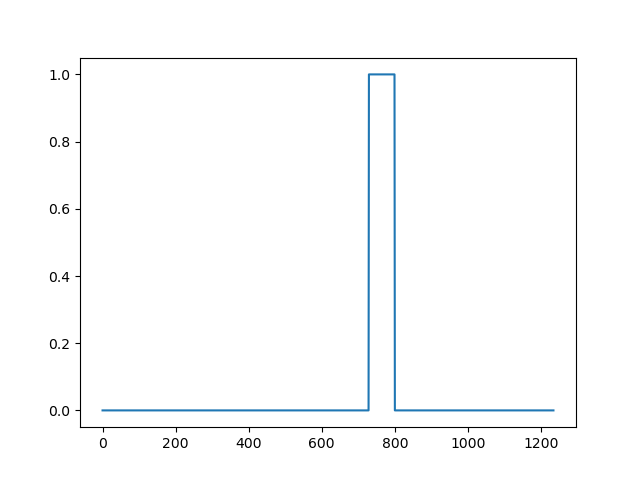

In [147]:
plt.figure()
plt.plot(tess.tpf.quality>0)


<IPython.core.display.Javascript object>


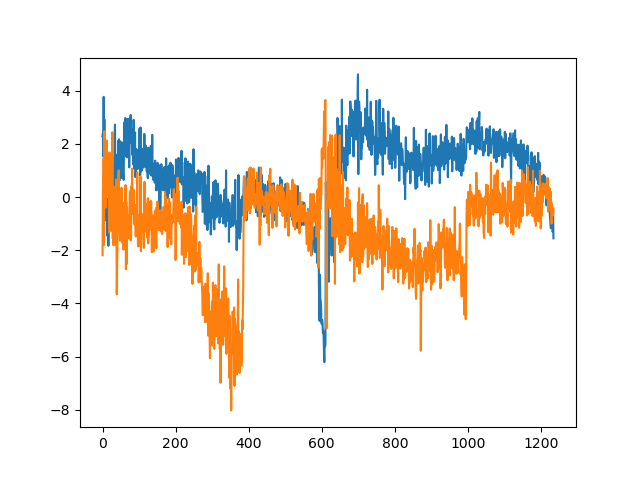

In [140]:
plt.figure()
plt.plot(tess.flux[:,45,45])
plt.plot(tess.flux[:,46,45])

In [125]:
f2 = deepcopy(tess.tpf.flux.value)
f2 -= np.nanmedian(f2,axis=(1,2))[:,np.newaxis,np.newaxis]

In [126]:
cors2 = np.zeros_like(tess.flux[0])
for i in range(len(inds[0])):
    t1 = f2[:,45,45]
    t2 = f2[:,inds[0][i],inds[1][i]]
    finite = np.isfinite(t1) & np.isfinite(t2)
    t1 = savgol_filter(t1[finite],13,1); t2 = savgol_filter(t2[finite],13,1)
    cors2[inds[0][i],inds[1][i]] = pearsonr(t1,t2)[0]
#cors[42:48,42:48] = 0

<IPython.core.display.Javascript object>


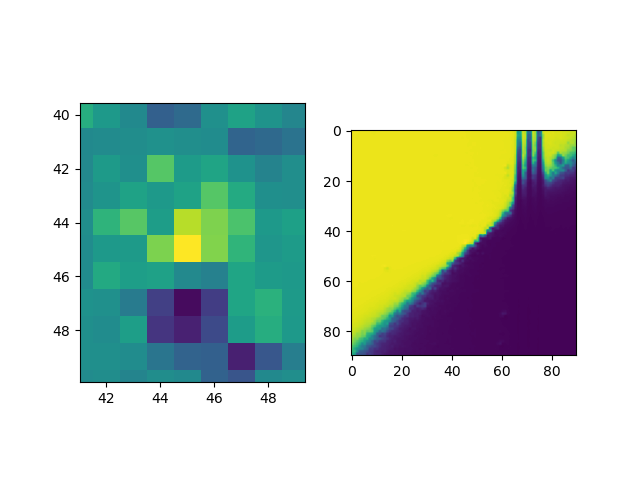

In [127]:
plt.figure()
plt.subplot(121)
plt.imshow(cors)
plt.subplot(122)
plt.imshow(cors2)